In [1]:
import pandas as pd
import numpy as np
import os
import shutil
from tqdm import tqdm
from glob import glob
import librosa

In [2]:
# glob로 test data의 path를 불러옴. 순서대로 로드되지 않을 경우를 주의
# test_ 데이터 프레임을 만들어 나중에 sample_submission과 id를 기준으로 merge시킬 준비

def get_id(data):
    return int(os.path.split(data)[-1].split(".")[0])

test_ = pd.DataFrame(index = range(0, 6100), columns = ["path", "id"])
test_["path"] = glob("./data/test/*.wav")
test_["id"] = test_["path"].apply(lambda x : get_id(x))

test_.head()

,path,id
0,./data/test/4737.wav,4737
1,./data/test/793.wav,793
2,./data/test/1961.wav,1961
3,./data/test/5574.wav,5574
4,./data/test/1618.wav,1618


In [3]:
train_x = np.load("./npy_data/train_x.npy")
train_y = np.load("./npy_data/train_y.npy")
test_x = np.load("./npy_data/test_x.npy")

print(train_x.shape, train_x.dtype)
print(train_y.shape, train_y.dtype)
print(test_x.shape, test_x.dtype)

(25520, 64, 501, 1) float32
(25520,) int64
(6100, 64, 501, 1) float32


# MLP Model

In [4]:
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras
import matplotlib.pyplot as plt

436 - val_accuracy: 0.4685
Epoch 63/200
559/559 [==============================] - 4s 8ms/step - loss: 1.5578 - accuracy: 0.4463 - val_loss: 1.5414 - val_accuracy: 0.4651
Epoch 64/200
559/559 [==============================] - 5s 9ms/step - loss: 1.5455 - accuracy: 0.4488 - val_loss: 1.5251 - val_accuracy: 0.4720
Epoch 65/200
559/559 [==============================] - 4s 7ms/step - loss: 1.5254 - accuracy: 0.4613 - val_loss: 1.5229 - val_accuracy: 0.4660
Epoch 66/200
559/559 [==============================] - 5s 8ms/step - loss: 1.5296 - accuracy: 0.4523 - val_loss: 1.5176 - val_accuracy: 0.4704
Epoch 67/200
559/559 [==============================] - 4s 8ms/step - loss: 1.5146 - accuracy: 0.4592 - val_loss: 1.5128 - val_accuracy: 0.4673
Epoch 68/200
559/559 [==============================] - 5s 8ms/step - loss: 1.5150 - accuracy: 0.4593 - val_loss: 1.5129 - val_accuracy: 0.4764
Epoch 69/200
559/559 [==============================] - 4s 7ms/step - loss: 1.5042 - accuracy: 0.4638 - val_l

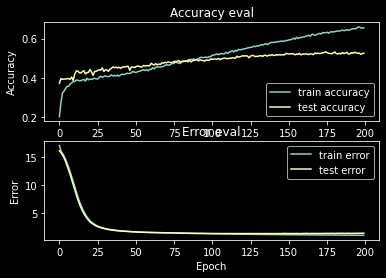

In [5]:
def plot_history(history):
  
  fig, axs = plt.subplots(2)

  # create accuracy sublpot
  axs[0].plot(history.history["accuracy"], label="train accuracy")
  axs[0].plot(history.history["val_accuracy"], label="test accuracy")
  axs[0].set_ylabel("Accuracy")
  axs[0].legend(loc="lower right")
  axs[0].set_title("Accuracy eval")
  # create error sublpot
  axs[1].plot(history.history["loss"], label="train error")
  axs[1].plot(history.history["val_loss"], label="test error")
  axs[1].set_ylabel("Error")
  axs[1].set_xlabel("Epoch")
  axs[1].legend(loc="upper right")
  axs[1].set_title("Error eval")
  plt.show()


if __name__ == "__main__" :

  # split the data into train and test sets
  X_train, X_test, y_train, y_test = train_test_split(train_x, train_y, test_size=0.3)
  
  # build the network architecture
  model = keras.Sequential([
                            
      # input layer
      keras.layers.Flatten(input_shape=(train_x.shape[1], train_x.shape[2], train_x.shape[3])),  # 1차원으로 flatten

      # 1st dense layer
      keras.layers.Dense(512, activation="relu", kernel_regularizer=keras.regularizers.l2(0.01)),
      keras.layers.Dropout(0.7),  

      # 2nd dense layer
      keras.layers.Dense(256, activation="relu", kernel_regularizer=keras.regularizers.l2(0.01)),
      keras.layers.Dropout(0.7),

      # 3rd dense layer
      keras.layers.Dense(64, activation="relu", kernel_regularizer=keras.regularizers.l2(0.01)),
      keras.layers.Dropout(0.7),

      # output layer
      keras.layers.Dense(6, activation="softmax")
  ])

  # compile model(network)
  optimizer = keras.optimizers.Adam(learning_rate=0.00001)
  model.compile(optimizer=optimizer,
                loss="sparse_categorical_crossentropy",
                metrics=["accuracy"])
  
  model.summary()

  # train model
  history = model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=32, epochs=200)

  # plot accuracy and error over the epochs
  plot_history(history)

In [14]:
pred = []
pred_ = []

pred.append(model.predict(test_x))
pred_.append(np.argmax(model.predict(test_x), axis = 1))

In [15]:
pred[0]

array([[0.01930903, 0.00515125, 0.00546744, 0.6386334 , 0.00544668,
        0.32599217],
       [0.13228427, 0.00704071, 0.00657841, 0.15264748, 0.02978674,
        0.6716624 ],
       [0.05656515, 0.00648284, 0.00661621, 0.16647656, 0.02440702,
        0.73945224],
       ...,
       [0.00846971, 0.00193045, 0.00201809, 0.8411756 , 0.00145455,
        0.14495167],
       [0.04028086, 0.00699084, 0.00710705, 0.34225026, 0.01497388,
        0.58839715],
       [0.08095033, 0.01733884, 0.01764235, 0.2428956 , 0.03889668,
        0.60227615]], dtype=float32)

In [16]:
sample_submission = pd.read_csv("./data/sample_submission.csv")

In [17]:
def cov_type(data):
    return np.int(data)

# glob로 로드한 test data의 path는 sample_submission의 id와 같이 1,2,3,4,5 순으로 정렬 되어있지 않음
# 만들어둔 test_ 데이터프레임을 이용하여 sample_submission과 predict값의 id를 맞춰줌

result = pd.concat([test_, pd.DataFrame(pred[0])], axis = 1).iloc[:, 1:]
result["id"] = result["id"].apply(lambda x : cov_type(x))

result = pd.merge(sample_submission["id"], result)
result.columns = sample_submission.columns

<ipython-input-17-5efccd9c85fc>:2: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return np.int(data)


In [18]:
result.to_csv(os.path.join('result', 'test_k_mlp_d0.7_lr0.00001_e200_bat32_0604_0450.csv'), index = False)
result

,id,africa,australia,canada,england,hongkong,us
0,1,0.080152,0.024557,0.025399,0.347364,0.037754,0.484773
1,2,0.032764,0.003083,0.002716,0.738461,0.003734,0.219241
2,3,0.251518,0.013262,0.010974,0.271982,0.032572,0.419693
3,4,0.499260,0.004577,0.003203,0.163146,0.019161,0.310653
4,5,0.027477,0.002636,0.002751,0.203772,0.009809,0.753556
...,...,...,...,...,...,...,...
6095,6096,0.006398,0.000343,0.000369,0.164836,0.001912,0.826142
6096,6097,0.018384,0.002372,0.002385,0.563603,0.003985,0.409270
6097,6098,0.002242,0.000153,0.000162,0.682336,0.000303,0.314803
6098,6099,0.162056,0.019106,0.017875,0.226121,0.047565,0.527277
